In [136]:
import nltk
import string
import PyPDF2
import os
import spacy
import string
import numpy as np

nlp = spacy.load('en_core_web_sm')

import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from wordcloud import WordCloud
import pandas as pd

import networkx as nx
from itertools import combinations
from networkx.algorithms import community

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

### Uploading Reports

In [71]:
#Loop that goes through each of the reports in the 'reports' folder, and turns them into strings, and removes the line breaks.

pdf_folder = 'reports'
pdf_texts = {}

# Loop through all PDFs
for filename in os.listdir(pdf_folder):
    if filename.endswith('.pdf'):
        report_name = filename.replace('.pdf', '').lower()
        with open(os.path.join(pdf_folder, filename), 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            text = ""
            for page in reader.pages:
                content = page.extract_text()
                if content:
                    text += content + "\n"
            pdf_texts[report_name] = text

In [72]:
ubs24 = pdf_texts['ubs_24']
ubs23 = pdf_texts['ubs_23']
ubs22 = pdf_texts['ubs_22']
pwc24 = pdf_texts['pwc_24']
pwc23 = pdf_texts['pwc_23']
pwc22 = pdf_texts['pwc_22']
citi24 = pdf_texts['citi_24']
citi23 = pdf_texts['citi_23']
citi22 = pdf_texts['citi_22']
campden24 = pdf_texts['campden_24']
campden23 = pdf_texts['campden_23']
campden22 = pdf_texts['campden_22']

### Cleaning the text

Creating a loop function that cleans the text so that I can go through each of the reports

In [73]:
def clean_text_spacy(text):
    # Process the text with spaCy
    doc = nlp(text)

    # Remove punctuation, stop words, and non-alphabetic tokens
    cleaned_tokens = [
        token.text.lower() for token in doc if token.text not in string.punctuation and not token.is_stop and token.is_alpha
    ]

    # Join the tokens back into a single string
    cleaned_text = ' '.join(cleaned_tokens)

    return cleaned_text

In [74]:
ubs24_basic = clean_text_spacy(ubs24)
ubs23_basic = clean_text_spacy(ubs23)
ubs22_basic = clean_text_spacy(ubs22)
pwc24_basic = clean_text_spacy(pwc24)
pwc23_basic = clean_text_spacy(pwc23)
pwc22_basic = clean_text_spacy(pwc22)
citi24_basic = clean_text_spacy(citi24)
citi23_basic = clean_text_spacy(citi23)
citi22_basic = clean_text_spacy(citi22)
campden24_basic = clean_text_spacy(campden24)
campden23_basic = clean_text_spacy(campden23)
campden22_basic = clean_text_spacy(campden22)

### Tokenising
Tokenising both by words and by sentences so that I can do different analysis. Start with just doing by word 

In [75]:
nlp = spacy.load("en_core_web_sm")

def get_word_tokens(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_space]
    return tokens

### Lemmatising

In [76]:
def lemmatize_words(word_tokens):
    lemmatized_words = []
    for word in word_tokens:
        # Process each word with spaCy
        doc = nlp(word)

        # Lemmatize the word
        lemmatized_word = doc[0].lemma_

        lemmatized_words.append(lemmatized_word)

    return lemmatized_words

In [78]:
ubs24_clean = lemmatize_words(get_word_tokens(ubs24_basic))
ubs23_clean = lemmatize_words(get_word_tokens(ubs23_basic))
ubs22_clean = lemmatize_words(get_word_tokens(ubs22_basic))
pwc24_clean = lemmatize_words(get_word_tokens(pwc24_basic))
pwc23_clean = lemmatize_words(get_word_tokens(pwc23_basic))
pwc22_clean = lemmatize_words(get_word_tokens(pwc22_basic))
citi24_clean = lemmatize_words(get_word_tokens(citi24_basic))
citi23_clean = lemmatize_words(get_word_tokens(citi23_basic))
citi22_clean = lemmatize_words(get_word_tokens(citi22_basic))
campden24_clean = lemmatize_words(get_word_tokens(campden24_basic))
campden23_clean = lemmatize_words(get_word_tokens(campden23_basic))
campden22_clean = lemmatize_words(get_word_tokens(campden22_basic))

### EDA

In [33]:
reports = {
    'ubs24': ubs24_clean,
    'ubs23': ubs23_clean,
    'ubs22': ubs22_clean,
    'pwc24': pwc24_clean,
    'pwc23': pwc23_clean,
    'pwc22': pwc22_clean,
    'citi24': citi24_clean,
    'citi23': citi23_clean,
    'citi22': citi22_clean,
    'campden24': campden24_clean,
    'campden23': campden23_clean,
    'campden22': campden22_clean,
}

In [34]:
report_frequencies = {name: Counter(tokens) for name, tokens in reports.items()}

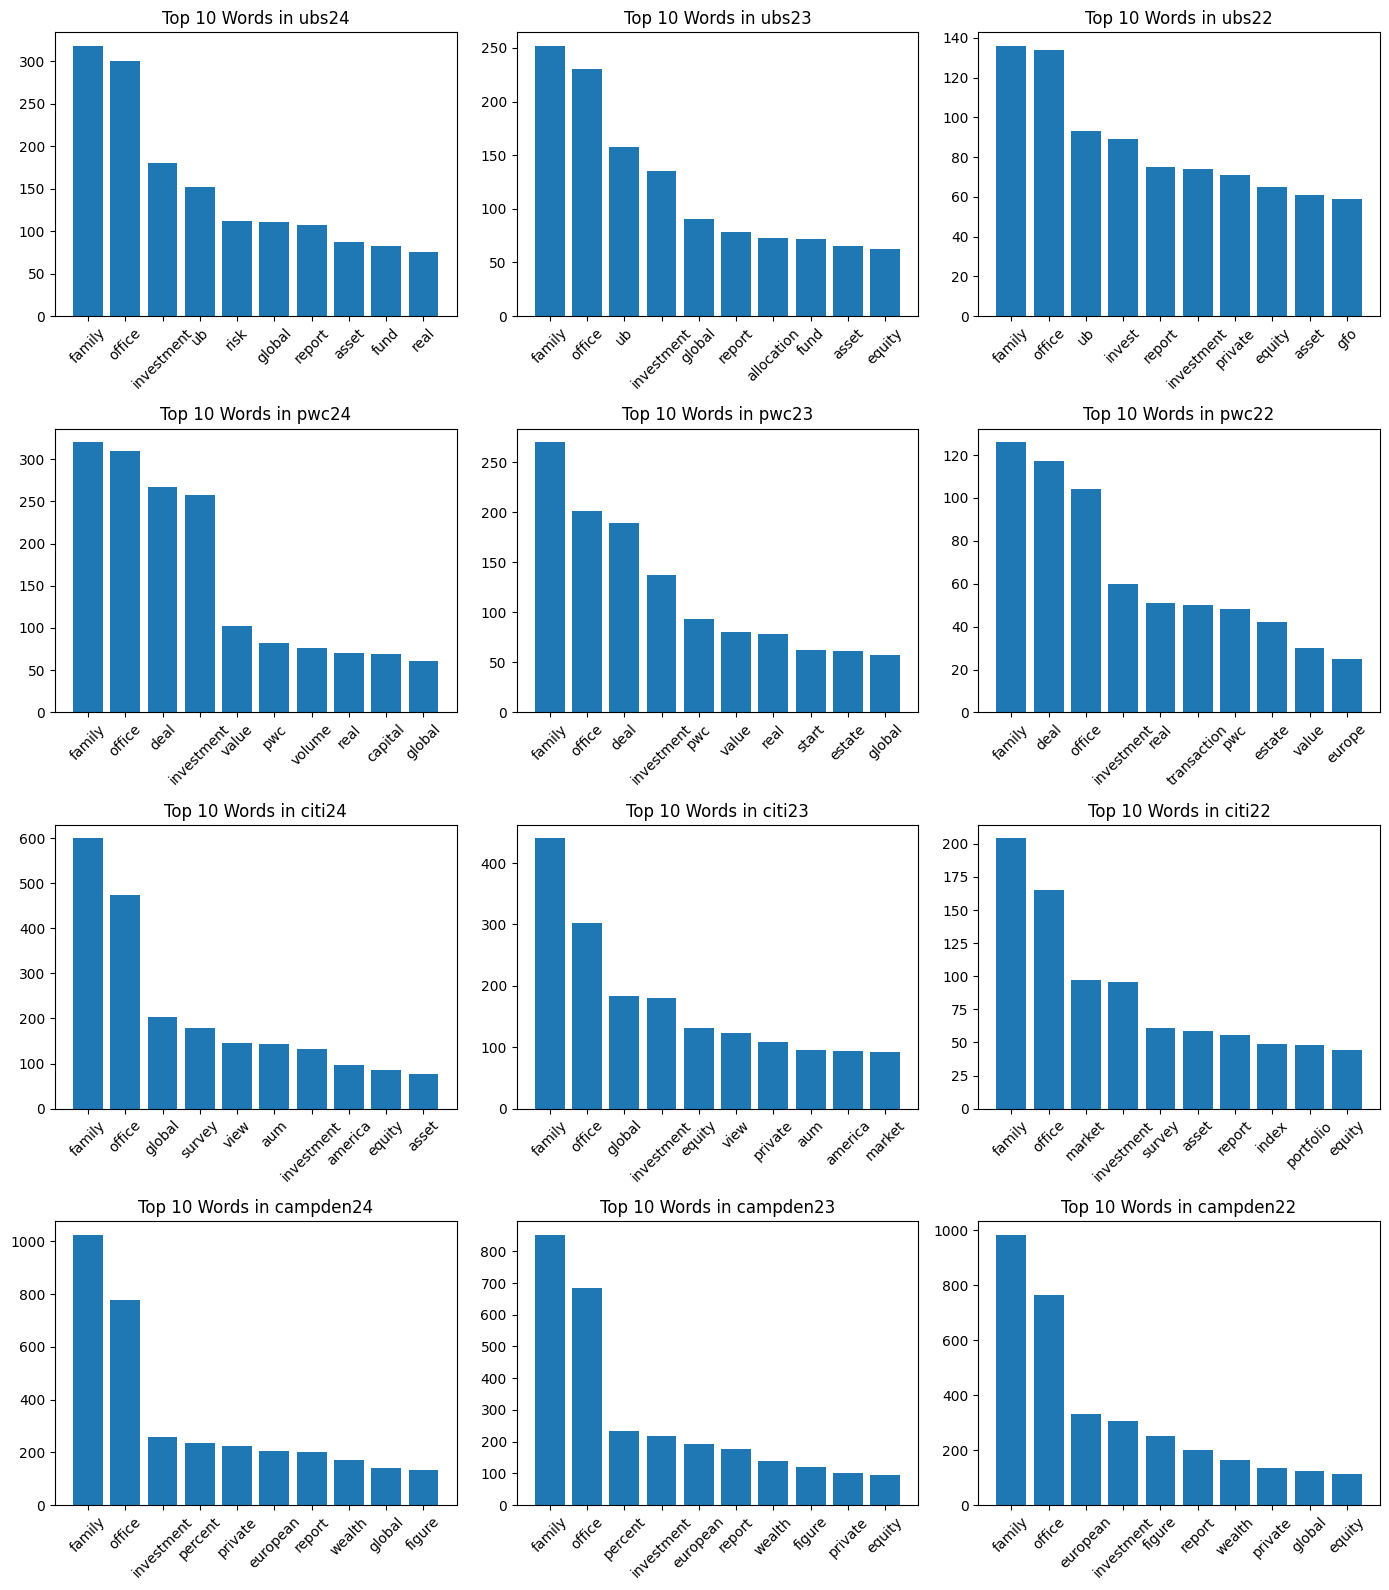

In [35]:
num_reports = len(report_frequencies)
cols = 3
rows = (num_reports + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4))
axes = axes.flatten()

plot_idx = 0  # use a separate index for valid subplots

for name, freq in report_frequencies.items():
    common = freq.most_common(10)
    if not common:
        print(f"⚠️ Skipping {name} - no word frequencies.")
        continue

    words, counts = zip(*common)
    
    ax = axes[plot_idx]
    ax.bar(words, counts)
    ax.set_title(f"Top 10 Words in {name}")
    ax.tick_params(axis='x', rotation=45)
    
    plot_idx += 1

# Hide any unused subplots
for i in range(plot_idx, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [36]:
keywords = ['sustainable', 'impact', 'sustainability', 'environmental', 'philanthropy', 'philanthropic', 'climate', 'governance']

for name, freq in report_frequencies.items():
    print(f"\n{name}")
    for word in keywords:
        print(f"  {word}: {freq[word]}")


ubs24
  sustainable: 2
  impact: 21
  sustainability: 21
  environmental: 1
  philanthropy: 5
  philanthropic: 1
  climate: 19
  governance: 7

ubs23
  sustainable: 4
  impact: 4
  sustainability: 1
  environmental: 1
  philanthropy: 2
  philanthropic: 0
  climate: 0
  governance: 9

ubs22
  sustainable: 17
  impact: 16
  sustainability: 5
  environmental: 2
  philanthropy: 2
  philanthropic: 0
  climate: 3
  governance: 1

pwc24
  sustainable: 13
  impact: 48
  sustainability: 6
  environmental: 3
  philanthropy: 0
  philanthropic: 0
  climate: 7
  governance: 0

pwc23
  sustainable: 3
  impact: 3
  sustainability: 1
  environmental: 1
  philanthropy: 0
  philanthropic: 0
  climate: 2
  governance: 2

pwc22
  sustainable: 0
  impact: 0
  sustainability: 0
  environmental: 0
  philanthropy: 0
  philanthropic: 0
  climate: 0
  governance: 0

citi24
  sustainable: 19
  impact: 7
  sustainability: 4
  environmental: 8
  philanthropy: 7
  philanthropic: 17
  climate: 2
  governance: 27

c

In [37]:
#plot keyword counts over time
reports_2022 = ['ubs22', 'pwc22', 'citi22', 'campden22']
reports_2023 = ['ubs23', 'pwc23', 'citi23', 'campden23']
reports_2024 = ['ubs24', 'pwc24', 'citi24', 'campden24']

# Define keywords
keywords = ['sustainable', 'impact', 'sustainability', 'environmental', 
            'philanthropy', 'philanthropic', 'climate', 'governance']

# Count keyword appearances across reports in each year
def count_keywords(reports, keyword_list):
    counts = {kw: 0 for kw in keyword_list}
    for name in reports:
        freq = report_frequencies.get(name, {})
        for kw in keyword_list:
            counts[kw] += freq.get(kw, 0)
    return counts

counts_2022 = count_keywords(reports_2022, keywords)
counts_2023 = count_keywords(reports_2023, keywords)
counts_2024 = count_keywords(reports_2024, keywords)

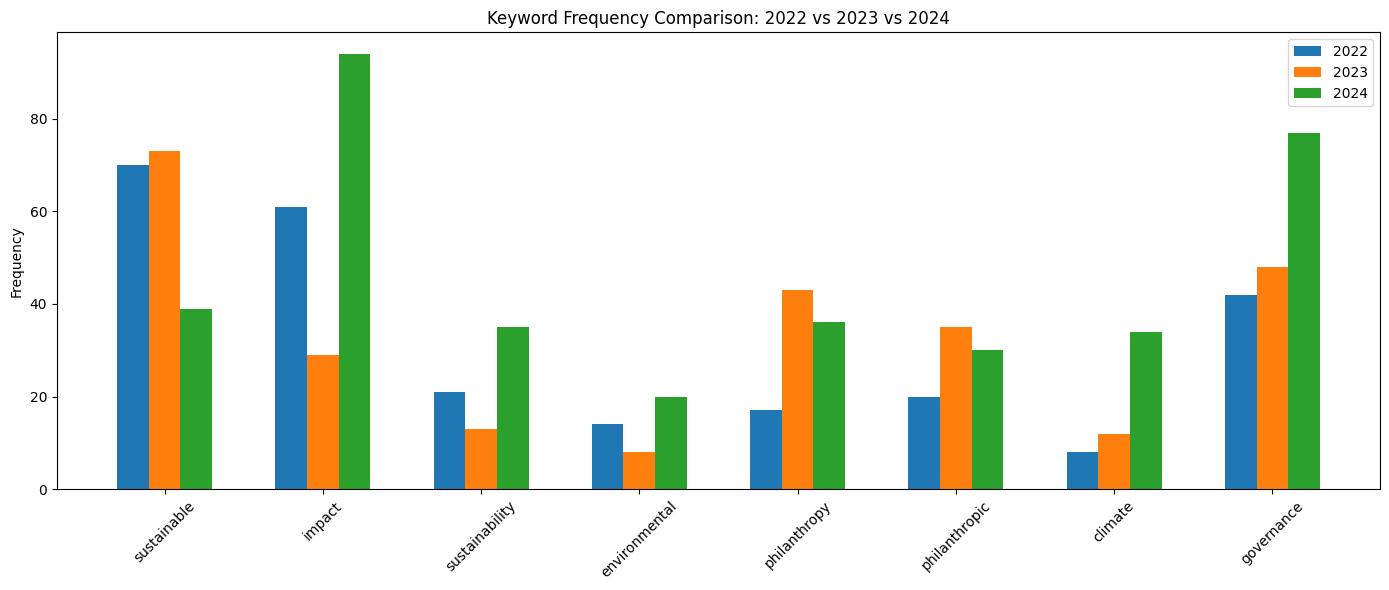

In [45]:
labels = keywords
x = np.arange(len(labels)) * 2  
width = 0.4  

fig, ax = plt.subplots(figsize=(14, 6))
bar1 = ax.bar(x - width, [counts_2022.get(kw, 0) for kw in labels], width, label='2022')
bar2 = ax.bar(x,         [counts_2023.get(kw, 0) for kw in labels], width, label='2023')
bar3 = ax.bar(x + width, [counts_2024.get(kw, 0) for kw in labels], width, label='2024')

# Add labels and formatting
ax.set_ylabel('Frequency')
ax.set_title('Keyword Frequency Comparison: 2022 vs 2023 vs 2024')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

### N-Gram Analysis

N-Gram analysis on the whole dataset

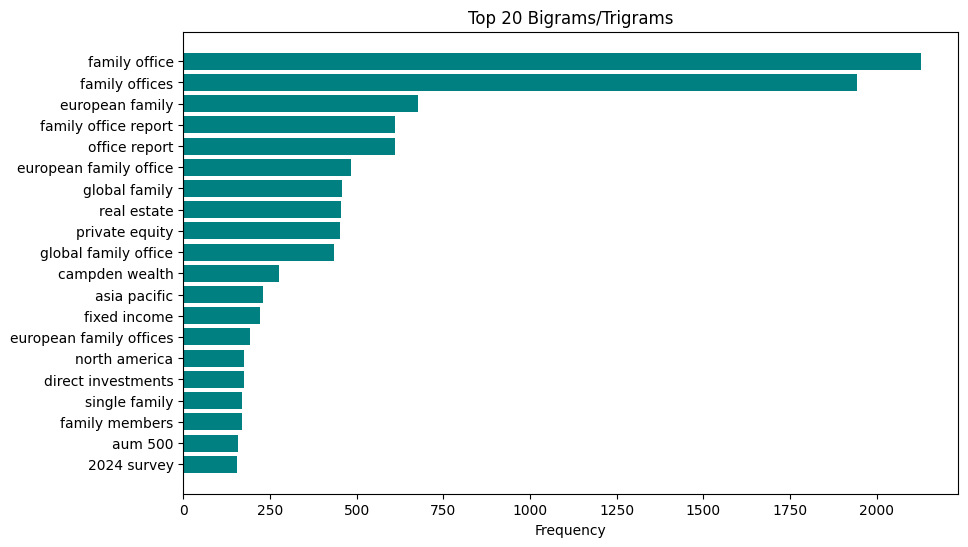

                          ngram  count
63993             family office   2128
64396            family offices   1944
59969           european family    677
64297      family office report    611
102040            office report    611
59970    european family office    483
72288             global family    458
119751              real estate    455
115686           private equity    453
72292      global family office    436
37537            campden wealth    277
30290              asia pacific    230
67720              fixed income    222
59971   european family offices    192
99811             north america    176
52287        direct investments    175
133219            single family    170
63814            family members    170
31909                   aum 500    158
8420                2024 survey    154


In [46]:
documents = [ubs24, ubs23, ubs22, pwc24, pwc23, pwc22, citi24, citi23, citi22, campden24, campden23, campden22]

# Create a bigram/trigram vectorizer
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
X = vectorizer.fit_transform(documents)

# Sum up the counts of each bigram
bigrams = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

# Create a DataFrame for easy viewing
bigram_freq = pd.DataFrame({'ngram': bigrams, 'count': counts})
bigram_freq = bigram_freq.sort_values(by='count', ascending=False)

# Plot the top 20 bigrams
top_bigrams = bigram_freq.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_bigrams['ngram'], top_bigrams['count'], color='teal')
plt.xlabel('Frequency')
plt.title('Top 20 Bigrams/Trigrams')
plt.gca().invert_yaxis()  # To display the highest counts at the top
plt.show()

# Show top 20 bigrams/trigrams
print(bigram_freq.head(20))

N-Gram analysis on keywords

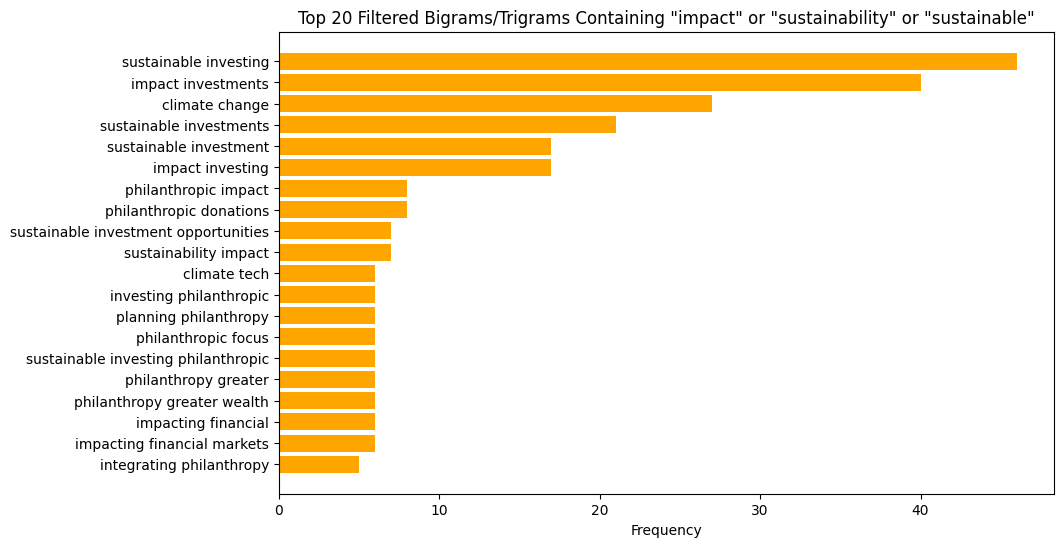

                                       ngram  count
103898                 sustainable investing     46
57215                     impact investments     40
30475                         climate change     27
103938               sustainable investments     21
103931                sustainable investment     17
57195                       impact investing     17
82201                   philanthropic impact      8
82161                philanthropic donations      8
103934  sustainable investment opportunities      7
103823                 sustainability impact      7
30512                           climate tech      6
61454                investing philanthropic      6
82992                  planning philanthropy      6
82182                    philanthropic focus      6
103921   sustainable investing philanthropic      6
82292                   philanthropy greater      6
82293            philanthropy greater wealth      6
57303                    impacting financial      6
57304       

In [48]:
# List of documents (cleaned text)
documents = [ubs24, ubs23, pwc24, pwc23, citi24, citi23, campden24, campden23]

# Create a bigram/trigram vectorizer
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
X = vectorizer.fit_transform(documents)

# Sum up the counts of each bigram
n_grams = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

# Create a DataFrame for easy viewing
ngram_freq = pd.DataFrame({'ngram': n_grams, 'count': counts})
ngram_freq = ngram_freq.sort_values(by='count', ascending=False)

keywords = ['impact', 'sustainable', 'sustainability', 'philanthropy', 'philanthropic', 'climate']
filtered_ngrams = ngram_freq[ngram_freq['ngram'].str.contains('|'.join(keywords))]

top_20_filtered_ngrams = filtered_ngrams.head(20)

# Plot the top 20 filtered bigrams/trigrams
plt.figure(figsize=(10, 6))
plt.barh(top_20_filtered_ngrams['ngram'], top_20_filtered_ngrams['count'], color='orange')
plt.xlabel('Frequency')
plt.title('Top 20 Filtered Bigrams/Trigrams Containing "impact" or "sustainability" or "sustainable"')
plt.gca().invert_yaxis()  # To display the highest counts at the top
plt.show()

# Show the top 20 filtered n-grams
print(top_20_filtered_ngrams)

### TF-IDF

See what words are distinctive or uniquely important in each report (or bank/year).

1. Each report as its own document 
2. Each bank as its own document 
3. Each year as its own document

### 1. Document Level

In [82]:
def ensure_string(doc):
    return ' '.join(doc) if isinstance(doc, list) else doc

documents = [ensure_string(doc) for doc in [
    ubs22_basic, ubs23_basic, ubs24_basic,
    citi22_basic, citi23_basic, citi24_basic,
    pwc22_basic, pwc23_basic, pwc24_basic,
    campden22_basic, campden23_basic, campden24_basic
]]

In [83]:
doc_labels = ['ubs_22', 'ubs_23', 'ubs24',
              'citi_22', 'citi_23', 'citi_24',
              'pwc_22', 'pwc_23', 'pwc_24',
              'campden_22', 'campden_23', 'campden_24']

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.85)
X = vectorizer.fit_transform(documents)
tfidf_df = pd.DataFrame(X.toarray(), index=doc_labels, columns=vectorizer.get_feature_names_out())

# Show top 10 terms per document
for doc in tfidf_df.index:
    print(f"\nTop terms in {doc}:")
    print(tfidf_df.loc[doc].sort_values(ascending=False).head(10))


Top terms in ubs_22:
ubs            0.608322
gfo            0.566757
costs          0.113209
western        0.111199
allocation     0.097119
staff          0.096075
income         0.093690
distributed    0.083037
ledger         0.082498
latin          0.082350
Name: ubs_22, dtype: float64

Top terms in ubs_23:
ubs            0.738285
allocations    0.138755
ag             0.134886
se             0.116817
bank           0.111607
offi           0.102933
ces            0.096070
authority      0.094777
german         0.088978
geopolitics    0.088500
Name: ubs_23, dtype: float64

Top terms in ubs24:
ubs            0.699203
income         0.189426
allocations    0.130658
operating      0.121750
rates          0.112557
ag             0.104832
se             0.101200
bank           0.097994
allocation     0.092055
plan           0.086116
Name: ubs24, dtype: float64

Top terms in citi_22:
survey        0.299535
citibank      0.275708
index         0.246738
aum           0.169736
citigroup     

### 2. Bank Level

In [84]:
bank_docs = {
    "UBS": ' '.join(documents[0:3]),
    "Citi": ' '.join(documents[3:6]),
    "PwC": ' '.join(documents[6:9]),
    "Campden": ' '.join(documents[9:12]),
}

In [85]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.85)
X = vectorizer.fit_transform(bank_docs.values())
tfidf_df_bank = pd.DataFrame(X.toarray(), index=bank_docs.keys(), columns=vectorizer.get_feature_names_out())

# Top terms per bank
for bank in tfidf_df_bank.index:
    print(f"\nTop terms for {bank}:")
    print(tfidf_df_bank.loc[bank].sort_values(ascending=False).head(10))


Top terms for UBS:
ubs            0.787555
allocations    0.155048
gfo            0.146243
allocation     0.128152
ag             0.115495
bank           0.113913
document       0.102838
plan           0.101256
operating      0.098091
unsplash       0.094190
Name: UBS, dtype: float64

Top terms for Citi:
survey         0.463460
view           0.368759
mm             0.272006
citibank       0.238287
vs             0.206815
respondents    0.189402
latin          0.163574
index          0.149226
citi           0.146119
citigroup      0.137127
Name: Citi, dtype: float64

Top terms for PwC:
pwc             0.669527
ofﬁces          0.354279
volume          0.254877
ofﬁce           0.249196
study           0.243379
club            0.175165
june            0.172473
transactions    0.122648
pitchbook       0.114090
ﬁrst            0.108085
Name: PwC, dtype: float64

Top terms for Campden:
percent       0.482354
campden       0.450367
figure        0.369318
fig           0.201520
hsbc          

### 3. Year Level

In [86]:
year_docs = {
    "2022": ' '.join([documents[0], documents[3], documents[6], documents[9]]),
    "2023": ' '.join([documents[1], documents[4], documents[7], documents[10]]),
    "2024": ' '.join([documents[2], documents[5], documents[8], documents[11]]),
}

In [87]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.85)
X = vectorizer.fit_transform(year_docs.values())
tfidf_df_year = pd.DataFrame(X.toarray(), index=year_docs.keys(), columns=vectorizer.get_feature_names_out())

# Top terms per year
for year in tfidf_df_year.index:
    print(f"\nTop terms for {year}:")
    print(tfidf_df_year.loc[year].sort_values(ascending=False).head(10))


Top terms for 2022:
gfo            0.580323
apply          0.321662
inhouse        0.196720
refinitiv      0.118032
overweight     0.112208
yesno          0.108196
underweight    0.097247
em             0.088524
learn          0.082286
fo             0.078688
Name: 2022, dtype: float64

Top terms for 2023:
ofﬁces      0.624058
ofﬁce       0.438956
fig         0.225240
ﬁrst        0.190391
amily       0.100484
ups         0.088487
controls    0.080443
offi        0.079329
ces         0.074041
bullish     0.072399
Name: 2023, dtype: float64

Top terms for 2024:
hsbc          0.589395
fig           0.373284
pitchbook     0.176819
infralogic    0.142080
disagree      0.122791
chart         0.122706
display       0.116248
volumedeal    0.109789
generative    0.109789
likelier      0.093321
Name: 2024, dtype: float64


Tracking for specific keywords
- tried doing this but didnt work very well as the frequencies arent that high compared to other words

### Semantic similarity modelling

In [101]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Initialize model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Your yearly documents
year_texts = list(year_docs.values())
years = list(year_docs.keys())

# Encode year documents
year_embeddings = model.encode(year_texts, convert_to_tensor=True)

# Define your concept phrase(s)
concepts = ["sustainability", "climate change", "social impact", "ESG", "impact investing", "governance", "sustainable investing", "SDG's", "philanthropy"]
concept_embeddings = model.encode(concepts, convert_to_tensor=True)

# Calculate similarity
similarities = util.cos_sim(concept_embeddings, year_embeddings)

# Display results
import pandas as pd
sim_df = pd.DataFrame(similarities.cpu().numpy(), index=concepts, columns=years)
print(sim_df.round(3))


                        2022   2023   2024
sustainability         0.218  0.134  0.171
climate change         0.067  0.042  0.125
social impact          0.211  0.137  0.202
ESG                   -0.005 -0.001 -0.045
impact investing       0.365  0.288  0.290
governance             0.184  0.131  0.148
sustainable investing  0.404  0.317  0.293
SDG's                  0.024 -0.011  0.004
philanthropy           0.222  0.164  0.121


In [105]:
print(sim_df.columns)


Index(['2022', '2023', '2024'], dtype='object')


### Cosine clustering

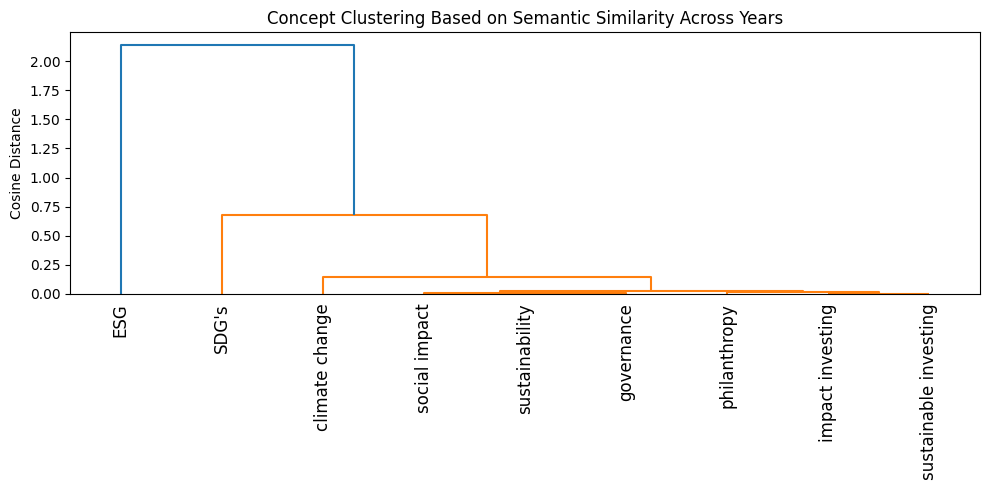

In [106]:
#df_sim = sim_df.set_index("concepts")  # if needed

# 2. Compute cosine distance matrix (1 - cosine similarity)
distance_matrix = pdist(sim_df.values, metric='cosine')

# 3. Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='ward')  # 'ward' or 'average'

# 4. Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=sim_df.index, leaf_rotation=90)
plt.title("Concept Clustering Based on Semantic Similarity Across Years")
plt.ylabel("Cosine Distance")
plt.tight_layout()
plt.show()

### Named Entity Recognition

used to identify and classify key information (entities) in text into predefined categories such as:

"ORG" - for organisations, locations, people

"PERSON" – for people

"GPE" – for countries, cities, states

"DATE" – for time-related entities

"MONEY" – for monetary values



In [108]:
year_docs

{'2022': 'global family office report foreword executive summary section asset allocation portfolio construction exploring new options unpredictable times section private equity favored source return section sustainable impact investing taking selective approach content section digital assets distributed ledgers crypto curious crypto committed section costs staffing mounting costs expected concluding remarks regional spotlights facts ubs gfo report josef stadler executive vice chairman ubs global wealth management ubs gfo report pleased present year global family office report share insights family office clients globe year compiling report entirely house thanks unique client base provides world largest comprehensive study single family offices year increased survey size single family offices collectively oversee wealth usd billion average assets management usd billion observing period substantial transformation areas pandemic digital disruption geopolitical ments driving profound chan

In [116]:
bank_docs

{'UBS': 'global family office report foreword executive summary section asset allocation portfolio construction exploring new options unpredictable times section private equity favored source return section sustainable impact investing taking selective approach content section digital assets distributed ledgers crypto curious crypto committed section costs staffing mounting costs expected concluding remarks regional spotlights facts ubs gfo report josef stadler executive vice chairman ubs global wealth management ubs gfo report pleased present year global family office report share insights family office clients globe year compiling report entirely house thanks unique client base provides world largest comprehensive study single family offices year increased survey size single family offices collectively oversee wealth usd billion average assets management usd billion observing period substantial transformation areas pandemic digital disruption geopolitical ments driving profound chang

In [119]:
ENTITY_TYPE = "GPE"  # Change this to GPE, PERSON, etc. if needed

# Loop through banks and extract entities
for year, text in year_docs.items():
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ == ENTITY_TYPE]
    top_entities = Counter(entities).most_common(10)
    
    print(f"\nTop {ENTITY_TYPE} entities for {year}:")
    for entity, count in top_entities:
        print(f"  {entity}: {count}")


Top GPE entities for 2022:
  united kingdom: 20
  london: 19
  china: 17
  switzerland: 12
  germany: 11
  france: 9
  spain: 8
  washington: 7
  netherlands: 7
  italy: 7

Top GPE entities for 2023:
  switzerland: 40
  hong kong: 27
  china: 26
  russia: 14
  germany: 14
  india: 10
  london: 9
  united kingdom: 9
  spain: 8
  singapore: 7

Top GPE entities for 2024:
  china: 29
  switzerland: 22
  france: 13
  germany: 13
  hong kong: 11
  united kingdom: 11
  russia: 9
  italy: 7
  spain: 7
  japan: 6


In [126]:
ENTITY_TYPE = "GPE"  # Change this to GPE, PERSON, etc. if needed

# Loop through banks and extract entities
for bank, text in bank_docs.items():
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ == ENTITY_TYPE]
    top_entities = Counter(entities).most_common(10)
    
    print(f"\nTop {ENTITY_TYPE} entities for {bank}:")
    for entity, count in top_entities:
        print(f"  {entity}: {count}")


Top GPE entities for UBS:
  switzerland: 33
  china: 25
  russia: 15
  israel: 8
  hong kong: 7
  singapore: 6
  pacific africa: 4
  uk: 4
  france: 4
  germany: 4

Top GPE entities for Citi:
  china: 29
  hong kong: 22
  london: 12
  japan: 10
  zurich: 9
  east africa: 8
  canada: 7
  russia: 7
  singapore: 5
  geneva: 4

Top GPE entities for PwC:
  germany: 20
  france: 15
  hong kong: 14
  india: 13
  london: 12
  pwc germany: 12
  paris: 11
  netherlands: 9
  spain: 8
  italy: 8

Top GPE entities for Campden:
  united kingdom: 35
  switzerland: 33
  germany: 14
  china: 14
  spain: 13
  london: 8
  luxembourg: 6
  france: 6
  italy: 5
  kingdom: 5


In [125]:
all_text = ' '.join(documents)

ENTITY_TYPE = "GPE"  # Change as needed

entities = [ent.text for ent in doc.ents if ent.label_ == ENTITY_TYPE]

top_entities = Counter(entities).most_common(10)
print(f"\nTop {ENTITY_TYPE} entities in all documents:")
for entity, count in top_entities:
    print(f"  {entity}: {count}")


Top GPE entities in all documents:
  china: 29
  switzerland: 22
  france: 13
  germany: 13
  hong kong: 11
  united kingdom: 11
  russia: 9
  italy: 7
  spain: 7
  japan: 6


### Network analysis of named entity

In [152]:
entity_docs = [
    list(set([ent.text for ent in nlp(doc).ents if ent.label_ == "GPE"])) 
    for doc in documents
]

# Flatten list of entities and get the top 20 most common
top_entities = [ent for ent, _ in Counter([ent for doc in entity_docs for ent in doc]).most_common(20)]

# Filter entity_docs to include only top entities
filtered_entity_docs = [
    [ent for ent in doc if ent in top_entities] 
    for doc in entity_docs
]

In [153]:
G = nx.Graph()

# Add nodes and edges based on filtered entities
for doc in filtered_entity_docs:
    for entity in doc:
        if not G.has_node(entity):
            G.add_node(entity)
        for other_entity in doc:
            if entity != other_entity:
                G.add_edge(entity, other_entity)
                

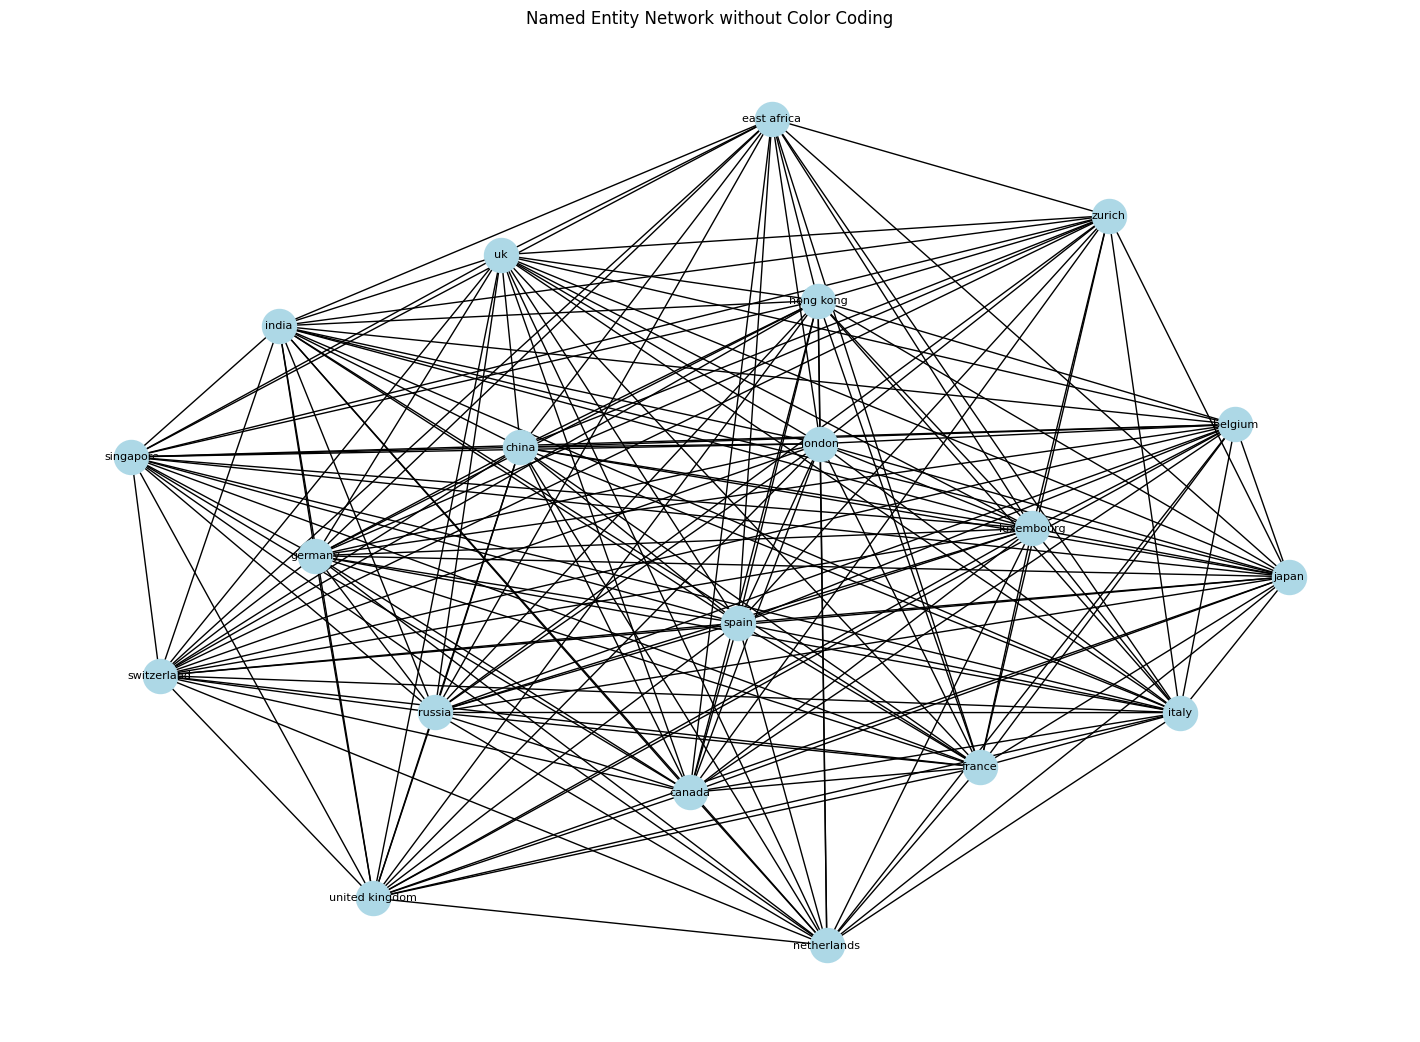

In [154]:
# Draw the graph with uniform color for all nodes
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=0.3)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=600, font_size=8)
plt.title("Named Entity Network without Color Coding")
plt.show()